In [6]:
# from google.colab import drive
# drive.mount('/content/drive')\

# file_path = '/content/drive/My Drive/EC ENGR 219 Large-Scale Data Mining: Models & Algorithms/Project 2/Steam Game Review - Datasets/main.csv'
file_path = 'Steam Game Review - Datasets/main.csv'
import pandas as pd
df_review = pd.read_csv(file_path)
df_review.head()

,user,playtime,post_date,helpfulness,review_text,recommend,early_access_review,appid,game_name,release_date,genres
0,Pakistan warrior,47.8,"November 3, 2023",3911,ALT + F4 best feature in the game 10/10,True,NaN,1938090,Call of Duty®,"Oct 27, 2022",Action
1,Zuvi,1969.8,"November 2, 2022",3154,"SPAWN DIE, SPAWN DIE, SPAWN DIE, SPAWN DIE.-Jev",True,NaN,1938090,Call of Duty®,"Oct 27, 2022",Action
2,SƎXSƎN,1190.7,"August 5, 2023",2821,"My wife said if this review gets 100 likes, I ...",True,NaN,1938090,Call of Duty®,"Oct 27, 2022",Action
3,Lunación,482.2,"November 10, 2023",2530,"Nobody will read my review, so I'll just say I...",True,NaN,1938090,Call of Duty®,"Oct 27, 2022",Action
4,Max,3.4,"July 11, 2024",2320,Nobody will read my review so i will do 1 push...,True,NaN,1938090,Call of Duty®,"Oct 27, 2022",Action


In [7]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

Using device: cuda
GPU: NVIDIA GeForce RTX 3060


In [8]:
# Task 1 - Unsupervised Review Length Discovery
# • Reviews in the top 25% (≥ q75) by length are labeled as Long,
# • Reviews in the bottom 25% (≤ q25) by length are labeled as Short,
# • Reviews in the middle 50% are discarded for this task.

# QUESTION 1: Report the number of reviews retained after filtering, and the average length (in tokens) of Short and Long reviews.
# Ans: 20497 reviews (after filtering); 493.0 average words for Long reviews, 6.4 average words for Short reviews

import numpy as np

df_review['review_length'] = df_review['review_text'].str.split().str.len()

q25 = df_review['review_length'].quantile(0.25) # 11.0
q75 = df_review['review_length'].quantile(0.75) # 179.0

print(q25, q75)

conditions = [
    df_review['review_length'] >= q75,
    df_review['review_length'] <= q25
]

df_review['review_length_type'] = np.select(conditions, ['Long', 'Short'], default='Discarded')

df_review_clean = df_review[df_review['review_length_type'] != 'Discarded']

display(df_review_clean.head())

print(f'Number of reviews, after filtering: {len(df_review_clean)}')
print(f'Average word length of Long reviews: { df_review_clean["review_length"][df_review_clean["review_length_type"]=="Long"].mean()}')
print(f'Average word length of Short reviews : {df_review_clean["review_length"][df_review_clean["review_length_type"]=="Short"].mean()}')

11.0 179.0


,user,playtime,post_date,helpfulness,review_text,recommend,early_access_review,appid,game_name,release_date,genres,review_length,review_length_type
0,Pakistan warrior,47.8,"November 3, 2023",3911,ALT + F4 best feature in the game 10/10,True,NaN,1938090,Call of Duty®,"Oct 27, 2022",Action,9,Short
1,Zuvi,1969.8,"November 2, 2022",3154,"SPAWN DIE, SPAWN DIE, SPAWN DIE, SPAWN DIE.-Jev",True,NaN,1938090,Call of Duty®,"Oct 27, 2022",Action,8,Short
3,Lunación,482.2,"November 10, 2023",2530,"Nobody will read my review, so I'll just say I...",True,NaN,1938090,Call of Duty®,"Oct 27, 2022",Action,11,Short
5,ORION,1165.6,"December 10, 2022",2245,Crash Of Duty : Update Requires Restart,True,NaN,1938090,Call of Duty®,"Oct 27, 2022",Action,7,Short
6,Bandy,1723.2,"October 29, 2022",2001,update requires restart,True,NaN,1938090,Call of Duty®,"Oct 27, 2022",Action,3,Short


Number of reviews, after filtering: 20497
Average word length of Long reviews: 493.00209288419376
Average word length of Short reviews : 6.391474720443467


In [9]:
# QUESTION 2: Report the dimensions of the TF-IDF matrix and the MiniLM embedding matrix.
# Briefly explain why TF-IDF is sparse while MiniLM embeddings are dense.

# Ans: TF-IDF matrix size: (20497, 25085), MiniLM embedding matrix size: (20497, 384)
# Also, TF-IDF is sparse because the feature dimensions comprise words obtained from the aggregated vocabulary of all review texts (25,085 words),
# where for a single review, this will only contain a small proportion of words, leaving most dimensions as zero.
# However for MiniLM, this uses a neural network to encode the review's semnatic meaning into a fixed 384-dimensional space,
# producing non-zero values in a dense vector embedding.

from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer

# 1. TF-IDF representation
print("Creating TF-IDF representation...")
tfidf_vectorizer = TfidfVectorizer(
    min_df=3,             # only include words that appear in at least 3 reviews
    stop_words='english',
    ngram_range=(1, 1)    # min. one word, max. one word
)
X_tfidf = tfidf_vectorizer.fit_transform(df_review_clean['review_text']) # Fit and transform the review texts
print(f"TF-IDF matrix shape: {X_tfidf.shape}")

# 2. MiniLM embeddings
print("\nCreating MiniLM embeddings...")
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
print(f"Embedding dimension: {model.get_sentence_embedding_dimension()}") # Check model embedding dimension
X_minilm = model.encode(
    df_review_clean['review_text'].tolist(),
    show_progress_bar=True,
    batch_size=32
)
print(f"MiniLM embedding matrix shape: {X_minilm.shape}")

Creating TF-IDF representation...
TF-IDF matrix shape: (20497, 25085)

Creating MiniLM embeddings...


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Embedding dimension: 384


Batches:   0%|          | 0/641 [00:00<?, ?it/s]

MiniLM embedding matrix shape: (20497, 384)


In [10]:
# QUESTION 3: For each pipeline, report the following clustering agreement metrics with respect
# to the ground-truth length labels: homogeneity, completeness, v-measure, ARI, AMI.
# Summarize results in a table and identify the best-performing pipeline.

# Ans: See results table below.
# Best score for Homogeneity: 0.777 is from MiniLM + SVD(50) + Agglomerative (n=2)
# Best score for Completeness: 0.777 is from MiniLM + SVD(50) + Agglomerative (n=2)
# Best score for V-Measure: 0.777 is from MiniLM + SVD(50) + Agglomerative (n=2)
# Best score for ARI: 0.862 is from MiniLM + SVD(50) + Agglomerative (n=2)
# Best score for AMI: 0.777 is from MiniLM + SVD(50) + Agglomerative (n=2)

from sklearn.decomposition import TruncatedSVD
from umap import UMAP
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import (
    homogeneity_score,
    completeness_score,
    v_measure_score,
    adjusted_rand_score,
    adjusted_mutual_info_score
)
from sklearn.neighbors import kneighbors_graph
import warnings
warnings.filterwarnings('ignore')

y_true = df_review_clean['review_length_type'].values
label_map = {'Short': 0, 'Long': 1}
y_true_binary = np.array([label_map[label] for label in y_true])

print(f'Total samples: {len(y_true_binary)}')
print(f'Short reviews: {np.sum(y_true_binary == 0)}')
print(f'Long reviews: {np.sum(y_true_binary == 1)}')

def evaluate_clustering(y_true, y_pred, pipeline):
    """Calculate all clustering metrics used to evaluate each pipeline"""
    metrics = {
        'Pipeline': pipeline,
        'Homogeneity': homogeneity_score(y_true, y_pred),
        'Completeness': completeness_score(y_true, y_pred),
        'V-Measure': v_measure_score(y_true, y_pred),
        'ARI': adjusted_rand_score(y_true, y_pred),
        'AMI': adjusted_mutual_info_score(y_true, y_pred)
    }
    return metrics

results = []

Total samples: 20497
Short reviews: 10463
Long reviews: 10034


In [11]:
# TF-IDF CLUSTERING PIPELINES

# # 1. TF-IDF + No Dimensionality Reduction + K-Means (k=2)
# try:
#     kmeans = KMeans(n_clusters=2, random_state=1, n_init=10)
#     y_pred = kmeans.fit_predict(X_tfidf)
#     results.append(evaluate_clustering(y_true_binary, y_pred, 'TF-IDF + No Dimensionality Reduction + K-Means (k=2)'))
# except Exception as e:
#     print(f"{e}; TF-IDF matrix is likely too large and sparse for efficient computation")

# # 2. TF-IDF + No Dimensionality Reduction + Agglomerative (n=2)
# try:
#     agg = AgglomerativeClustering(n_clusters=2, linkage='ward')
#     y_pred = agg.fit_predict(X_tfidf.toarray()) # conversion from sparse to dense input first
#     results.append(evaluate_clustering(y_true_binary, y_pred, 'TF-IDF + No Dimensionality Reduction + Agglomerative (n=2)'))
# except Exception as e:
#     print(f"{e}; agglomerative clustering requires dense input (not sparse); conversion requires high RAM")

# 3. TF-IDF + SVD(50) + K-Means (k=2)
svd_tfidf = TruncatedSVD(n_components=50, random_state=1)
X_tfidf_svd = svd_tfidf.fit_transform(X_tfidf)
print(f"Reduced matrix shape: {X_tfidf_svd.shape}")
kmeans = KMeans(n_clusters=2, random_state=1, n_init=10)
y_pred = kmeans.fit_predict(X_tfidf_svd)
results.append(evaluate_clustering(y_true_binary, y_pred, 'TF-IDF + SVD(50) + K-Means (k=2)'))

# 4. TF-IDF + SVD(50) + Agglomerative (n=2)
conn = kneighbors_graph(X_tfidf_svd, n_neighbors=10, mode='connectivity', include_self=False) # each point to consider 10 nearest neighbours
agg = AgglomerativeClustering(n_clusters=2, linkage='ward', connectivity=conn)                # leverage connectivity for faster computation
y_pred = agg.fit_predict(X_tfidf_svd)
results.append(evaluate_clustering(y_true_binary, y_pred, 'TF-IDF + SVD(50) + Agglomerative (n=2)'))

# # 5. TF-IDF + SVD(200) + UMAP(50) + K-Means (k=2)
# svd_pre = TruncatedSVD(n_components=200, random_state=1)
# X_tfidf_svd200 = svd_pre.fit_transform(X_tfidf)
# umap_tfidf = UMAP(n_components=50, random_state=1, n_neighbors=15, min_dist=0.1)
# X_tfidf_umap = umap_tfidf.fit_transform(X_tfidf_svd200)
# print(f"Reduced matrix shape: {X_tfidf_umap.shape}")
# kmeans = KMeans(n_clusters=2, random_state=1, n_init=10)
# y_pred = kmeans.fit_predict(X_tfidf_umap)
# results.append(evaluate_clustering(y_true_binary, y_pred, 'TF-IDF + SVD(200) + UMAP(50) + K-Means (k=2)'))

# # 6. TF-IDF + UMAP(50) + Agglomerative (n=2)
# conn = kneighbors_graph(X_tfidf_umap, n_neighbors=10, mode='connectivity', include_self=False)
# agg = AgglomerativeClustering(n_clusters=2, linkage='ward', connectivity=conn)
# y_pred = agg.fit_predict(X_tfidf_umap)
# results.append(evaluate_clustering(y_true_binary, y_pred, 'TF-IDF + UMAP(50) + Agglomerative (n=2)'))

Reduced matrix shape: (20497, 50)


In [12]:
# MiniLM PIPELINES

# 1. MiniLM + No Dimensionality Reduction + K-Means (k=2)
kmeans = KMeans(n_clusters=2, random_state=1, n_init=10)
y_pred = kmeans.fit_predict(X_minilm)
results.append(evaluate_clustering(y_true_binary, y_pred, 'MiniLM + No Dimensionality Reduction + K-Means (k=2)'))

# 2. MiniLM + No Dimensionality Reduction + Agglomerative (n=2)
conn = kneighbors_graph(X_minilm, n_neighbors=10, mode='connectivity', include_self=False)
agg = AgglomerativeClustering(n_clusters=2, linkage='ward', connectivity=conn)
y_pred = agg.fit_predict(X_minilm)
results.append(evaluate_clustering(y_true_binary, y_pred, 'MiniLM + No Dimensionality Reduction + Agglomerative (n=2)'))

# 3. MiniLM + SVD(50) + K-Means (k=2)
svd_minilm = TruncatedSVD(n_components=50, random_state=1)
X_minilm_svd = svd_minilm.fit_transform(X_minilm)
print(f"Reduced matrix shape: {X_minilm_svd.shape}")
kmeans = KMeans(n_clusters=2, random_state=1, n_init=10)
y_pred = kmeans.fit_predict(X_minilm_svd)
results.append(evaluate_clustering(y_true_binary, y_pred, 'MiniLM + SVD(50) + K-Means (k=2)'))

# 4. MiniLM + SVD(50) + Agglomerative (n=2)
conn = kneighbors_graph(X_minilm_svd, n_neighbors=10, mode='connectivity', include_self=False)
agg = AgglomerativeClustering(n_clusters=2, linkage='ward', connectivity=conn)
y_pred = agg.fit_predict(X_minilm_svd)
results.append(evaluate_clustering(y_true_binary, y_pred, 'MiniLM + SVD(50) + Agglomerative (n=2)'))

# 5. MiniLM + UMAP(50) + K-Means (k=2)
umap_minilm = UMAP(n_components=50, random_state=1, n_neighbors=15, min_dist=0.1)
X_minilm_umap = umap_minilm.fit_transform(X_minilm)
print(f"Reduced shape: {X_minilm_umap.shape}")
kmeans = KMeans(n_clusters=2, random_state=1, n_init=10)
y_pred = kmeans.fit_predict(X_minilm_umap)
results.append(evaluate_clustering(y_true_binary, y_pred, 'MiniLM + UMAP(50) + K-Means (k=2)'))

# 6. MiniLM + UMAP(50) + Agglomerative (n=2)
conn = kneighbors_graph(X_minilm_umap, n_neighbors=10, mode='connectivity', include_self=False)
agg = AgglomerativeClustering(n_clusters=2, linkage='ward', connectivity=conn)
y_pred = agg.fit_predict(X_minilm_umap)
results.append(evaluate_clustering(y_true_binary, y_pred, 'MiniLM + UMAP(50) + Agglomerative (n=2)'))


Reduced matrix shape: (20497, 50)
Reduced shape: (20497, 50)


In [13]:
results_df = pd.DataFrame(results)
metric_cols = ['Homogeneity', 'Completeness', 'V-Measure', 'ARI', 'AMI']
results_df[metric_cols] = results_df[metric_cols].round(3)

display(results_df)

for metric in metric_cols:
    best_idx = results_df[metric].idxmax()
    best_pipeline = results_df.loc[best_idx, 'Pipeline']
    best_score = results_df.loc[best_idx, metric]
    print(f"Best score for {metric}: {best_score:.3f} is from {best_pipeline}")

,Pipeline,Homogeneity,Completeness,V-Measure,ARI,AMI
0,TF-IDF + SVD(50) + K-Means (k=2),0.030,0.161,0.051,0.006,0.051
1,TF-IDF + SVD(50) + Agglomerative (n=2),0.036,0.168,0.059,0.008,0.059
2,MiniLM + No Dimensionality Reduction + K-Means...,0.509,0.510,0.510,0.613,0.510
3,MiniLM + No Dimensionality Reduction + Agglome...,0.532,0.534,0.533,0.637,0.533
4,MiniLM + SVD(50) + K-Means (k=2),0.511,0.511,0.511,0.615,0.511
5,MiniLM + SVD(50) + Agglomerative (n=2),0.777,0.777,0.777,0.862,0.777
6,MiniLM + UMAP(50) + K-Means (k=2),0.434,0.435,0.435,0.534,0.435
7,MiniLM + UMAP(50) + Agglomerative (n=2),0.507,0.509,0.508,0.614,0.508


Best score for Homogeneity: 0.777 is from MiniLM + SVD(50) + Agglomerative (n=2)
Best score for Completeness: 0.777 is from MiniLM + SVD(50) + Agglomerative (n=2)
Best score for V-Measure: 0.777 is from MiniLM + SVD(50) + Agglomerative (n=2)
Best score for ARI: 0.862 is from MiniLM + SVD(50) + Agglomerative (n=2)
Best score for AMI: 0.777 is from MiniLM + SVD(50) + Agglomerative (n=2)


In [14]:
# QUESTION 4: Compare TF-IDF and MiniLM performance on this task.
# Which representation separates Short vs Long reviews more cleanly, and why?

# Answer:
# MiniLM is able to separate Short vs Long reviews more cleanly than TF-IDF.

# Best performing pipeline (MiniLM + SVD(50) + Agglomerative (n=2) achieves a # V-Measure of 0.777,
# compared to TF-IDF's best performance of 0.059: TF-IDF + SVD(50) + Agglomerative (n=2)

# This is becuase:
# 1. Dense vs sparse representations
# TF-IDF loses information during SVD (length information relies on its sparse representation with multiple zero entries);
# however when compressed to 50 dimensions, the sparse signal becomes overly diluted.
# This is in comparison to MiniLM, which begins with a dense embedding (384 non-zero values),
# preserving rich distribution of information even after dimensionality reduction.

# 2. Semantic interpretation
# MiniLM is a Neural Network that considers a richer representation of the data, including context, semantic meaning and syntactic features;
# MiniLM could also pick up linguistic differences that occur with longer (e.g. complex sentence structure, or detailed descriptor words) vs. shorter review length.
# Whereas, TF-IDF considers primarily term frequency with respect to different review documents.

# 3. UMAP signal dilution
# Also, UMAP dimensionality reduction for MiniLM appears to weaken the length-based separation (V-Measure: 0.056),
# as UMAP relies on local neighbourhood structure to place semantically similar reviews close together (i.e. positive reviews clustered together).

In [15]:
# QUESTION 5: Plots and Visualization: Select the best-performing configuration for TF–IDF
# and MiniLM based on clustering performance. For each representation:

# • Reduce the embeddings to two dimensions using PCA (sklearn.decomposition.PCA).
# • Create a split visualization with:
# – One plot colored by the ground-truth length label.
# – One plot colored by the cluster assignments obtained using your best clustering method.

# The resulting plots should enable a direct visual comparison between the true labels and the
# discovered clusters for both TF–IDF and MiniLM representations, highlighting how well each
# representation supports unsupervised separation.

TF-IDF PCA dimension reduction: (20497, 50) -> (20497, 2)
MiniLM PCA dimension reduction: (20497, 50) -> (20497, 2)


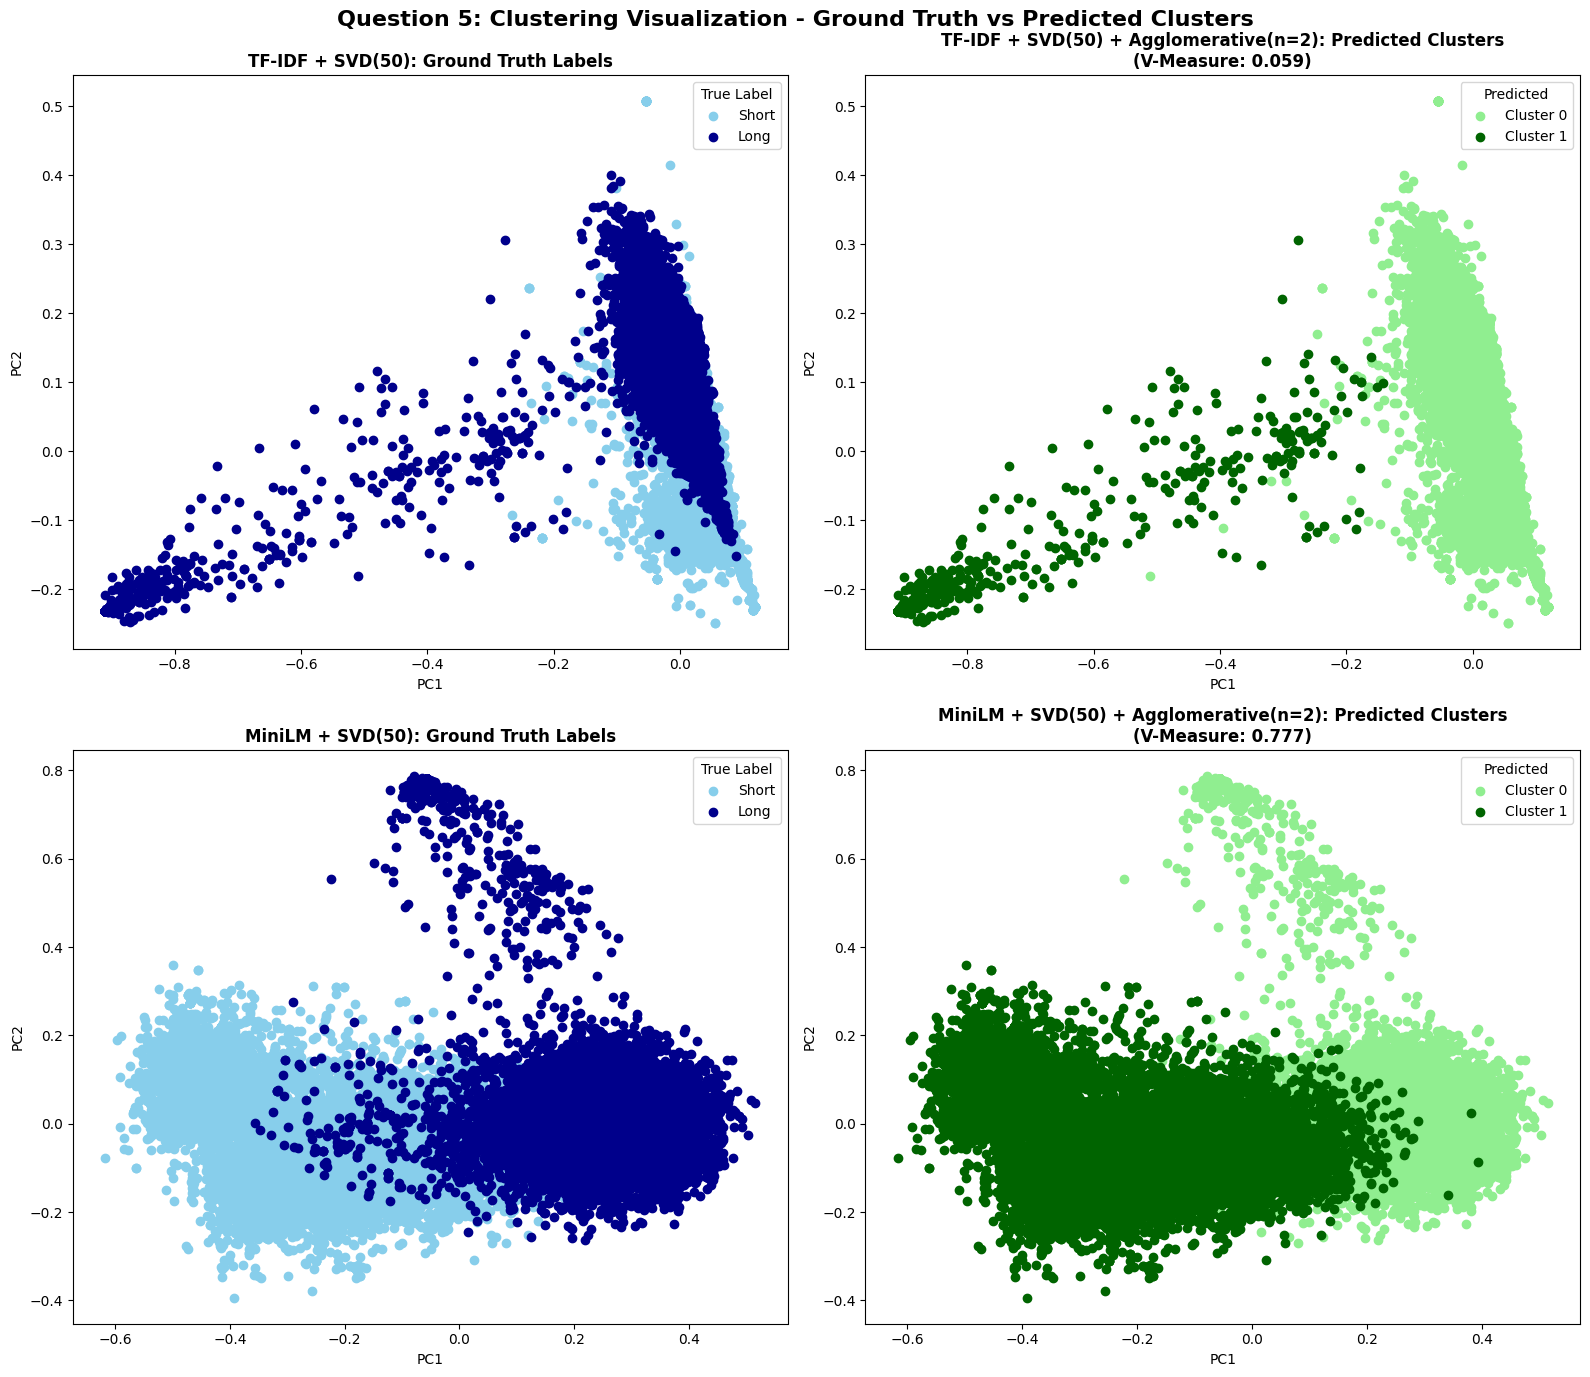

In [16]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# TF-IDF + SVD(50) + Agglomerative (n=2)
conn_tfidf = kneighbors_graph(X_tfidf_svd, n_neighbors=10, mode='connectivity', include_self=False)
agg_tfidf = AgglomerativeClustering(n_clusters=2, linkage='ward', connectivity=conn_tfidf)
y_pred_tfidf_best = agg_tfidf.fit_predict(X_tfidf_svd)

pca_tfidf = PCA(n_components=2, random_state=1)
X_tfidf_2d = pca_tfidf.fit_transform(X_tfidf_svd)
print(f"TF-IDF PCA dimension reduction: {X_tfidf_svd.shape} -> {X_tfidf_2d.shape}") # Represents review representation as a 2d-coordinate for plotting

# MiniLM + SVD(50) + Agglomerative (n=2)
conn_minilm = kneighbors_graph(X_minilm_svd, n_neighbors=10, mode='connectivity', include_self=False)
agg_minilm = AgglomerativeClustering(n_clusters=2, linkage='ward', connectivity=conn_minilm)
y_pred_minilm_best = agg_minilm.fit_predict(X_minilm_svd)

pca_minilm = PCA(n_components=2, random_state=1)
X_minilm_2d = pca_minilm.fit_transform(X_minilm_svd)
print(f"MiniLM PCA dimension reduction: {X_minilm_svd.shape} -> {X_minilm_2d.shape}") # Represents review embedding as a 2d-coordinate for plotting

true_colors = {0: '#87CEEB', 1: '#00008B'}  # Short    : Light Blue,  Long     : Dark Blue
pred_colors = {0: '#90EE90', 1: '#006400'}  # Cluster 0: Light Green, Cluster 1: Dark Green

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
fig.suptitle(
    'Question 5: Clustering Visualization - Ground Truth vs Predicted Clusters',
    fontsize=16, fontweight='bold'
)

# TF-IDF: Ground Truth
ax1 = axes[0, 0]
for label in [0, 1]:
    mask = y_true_binary == label
    label_name = 'Short' if label == 0 else 'Long'
    ax1.scatter(X_tfidf_2d[mask, 0], X_tfidf_2d[mask, 1],
               c=true_colors[label], label=label_name)
ax1.set_title('TF-IDF + SVD(50): Ground Truth Labels', fontsize=12, fontweight='bold')
ax1.set_xlabel(f'PC1', fontsize=10)
ax1.set_ylabel(f'PC2', fontsize=10)
ax1.legend(title='True Label', loc='best')

# TF-IDF: Predicted Clusters
ax2 = axes[0, 1]
for cluster in [0, 1]:
    mask = y_pred_tfidf_best == cluster
    ax2.scatter(X_tfidf_2d[mask, 0], X_tfidf_2d[mask, 1],
               c=pred_colors[cluster], label=f'Cluster {cluster}')

ax2.set_title(f'TF-IDF + SVD(50) + Agglomerative(n=2): Predicted Clusters\n(V-Measure: 0.059)', fontsize=12, fontweight='bold')
ax2.set_xlabel(f'PC1', fontsize=10)
ax2.set_ylabel(f'PC2', fontsize=10)
ax2.legend(title='Predicted', loc='best')


# MiniLM: Ground Truth
ax3 = axes[1, 0]
for label in [0, 1]:
    mask = y_true_binary == label
    label_name = 'Short' if label == 0 else 'Long'
    ax3.scatter(X_minilm_2d[mask, 0], X_minilm_2d[mask, 1],
               c=true_colors[label], label=label_name)

ax3.set_title('MiniLM + SVD(50): Ground Truth Labels', fontsize=12, fontweight='bold')
ax3.set_xlabel(f'PC1', fontsize=10)
ax3.set_ylabel(f'PC2', fontsize=10)
ax3.legend(title='True Label', loc='best')

# MiniLM: Predicted Clusters
ax4 = axes[1, 1]
for cluster in [0, 1]:
    mask = y_pred_minilm_best == cluster
    ax4.scatter(X_minilm_2d[mask, 0], X_minilm_2d[mask, 1],
               c=pred_colors[cluster], label=f'Cluster {cluster}')

ax4.set_title(f'MiniLM + SVD(50) + Agglomerative(n=2): Predicted Clusters\n(V-Measure: 0.777)', fontsize=12, fontweight='bold')
ax4.set_xlabel(f'PC1', fontsize=10)
ax4.set_ylabel(f'PC2', fontsize=10)
ax4.legend(title='Predicted', loc='best')

plt.tight_layout()
plt.show()

In [17]:
# Task 2 - Unsupervised Game Similarity & Genre Structure

# QUESTION 6: Report the dimensions of the TF-IDF game matrix and the MiniLM game embedding matrix
# Ans:  TF-IDF matrix size: (200, 16554), MiniLM embedding matrix size: (200, 384)

df_review_positive = df_review[df_review['recommend'] == True]
df_review_by_game = df_review_positive.groupby('game_name')['review_text'].apply(
    lambda reviews: ' '.join(reviews)
).reset_index()
df_review_by_game.columns = ['game_name', 'review_text_concat']


from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer

# 1. TF-IDF representation
print("Creating TF-IDF representation...")
tfidf_vectorizer = TfidfVectorizer(
    min_df=3,
    stop_words='english',
    ngram_range=(1, 1)
)
X_tfidf_positive = tfidf_vectorizer.fit_transform(df_review_by_game['review_text_concat'])
print(f"TF-IDF matrix shape: {X_tfidf_positive.shape}")

# 2. MiniLM embeddings
print("\nCreating MiniLM embeddings...")
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
print(f"Embedding dimension: {model.get_sentence_embedding_dimension()}")
X_minilm_positive = model.encode(
    df_review_by_game['review_text_concat'].tolist(),
    show_progress_bar=True,
    batch_size=32
)
print(f"MiniLM embedding matrix shape: {X_minilm_positive.shape}")

Creating TF-IDF representation...
TF-IDF matrix shape: (200, 16554)

Creating MiniLM embeddings...


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Embedding dimension: 384


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

MiniLM embedding matrix shape: (200, 384)


In [18]:
# QUESTION 7: For each pipeline, report a summary table that includes:
# • number of clusters found (for HDBSCAN, also report the fraction of games labeled as noise -1),
# • cluster sizes,
# • for each cluster: top 3 most common genres (by frequency across games in that cluster).

In [19]:
import torch
import torch.nn as nn
import warnings
warnings.filterwarnings('ignore')

# 0.1 Train Autoencoder (with latent_dim=50)

class Autoencoder(nn.Module):
  """ Define Autoencoder object """
  def __init__(self, input_dim, latent_dim=50):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Linear(input_dim, 256),
        nn.ReLU(),
        nn.Linear(256, latent_dim)
    )
    self.decoder = nn.Sequential(
        nn.Linear(latent_dim, 256),
        nn.ReLU(),
        nn.Linear(256, input_dim)
    )
  def forward(self, x):
    z = self.encoder(x)
    return self.decoder(z), z

def train_autoencoder(X_np, latent_dim=50, epochs=50, lr=1e-3):
    """Standalone training function"""
    device = 'cuda' if torch.cuda.is_available() else 'cpu'  # use GPU if available on Colab
    X_t = torch.tensor(X_np, dtype=torch.float32).to(device) # cnverts numpy array to a PyTorch tensor
    ae  = Autoencoder(X_np.shape[1], latent_dim).to(device)
    opt = torch.optim.Adam(ae.parameters(), lr=lr)           # Adam optimiser
    ae.train()
    for _ in range(epochs):
        opt.zero_grad()                                      # each epoch, clear gradients from the previous step
        decoded_output, _ = ae(X_t)
        nn.MSELoss()(decoded_output, X_t).backward()         # Mean squared error between decoded output and input
        opt.step()                                           # update model parameters using gradients
    ae.eval()
    with torch.no_grad():
        _, Z = ae(X_t)
    return Z.cpu().numpy()

In [20]:
# 0.2 Game genre lookup

from collections import Counter

game_genres_lookup = (
    df_review[['game_name', 'genres']]
    .drop_duplicates('game_name')
    .set_index('game_name')['genres']
    .reindex(df_review_by_game['game_name'])
    .fillna('')
)

def parse_genres(genre_str):
    return [g.strip() for g in genre_str.split(',') if g.strip()] if genre_str else []

all_game_genres = [parse_genres(g) for g in game_genres_lookup.values]

def top_three_genres(indices):
  """Find top 3 genres for each cluster"""
  counter = Counter()
  for idx in indices:
      for g in all_game_genres[idx]:
          counter[g] += 1
  return counter.most_common(3)


In [21]:
# 0.3 Summary of clustering

import numpy as np


def summary_of_clustering(pipeline_name, labels):
    n_tot       = len(labels)
    noise_count = int(np.sum(labels == -1))
    cluster_ids = sorted(l for l in set(labels) if l != -1)
    results.append({
        'Pipeline':   pipeline_name,
        'N Clusters': len(cluster_ids),
        'Noise':      f"{noise_count} ({noise_count/n_tot:.1%})",
        'Cluster Sizes': {cid: int(np.sum(labels == cid)) for cid in cluster_ids},
        'Top-three Genres':  {cid: top_three_genres(np.where(labels == cid)[0]) for cid in cluster_ids}
    })
    return labels


In [22]:
# TF-IDF CLUSTERING PIPELINES

from sklearn.decomposition import TruncatedSVD
from umap import UMAP
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
import hdbscan

results=[]


# 1. TF-IDF + SVD(50) + K-Means (k=5)
svd_tfidf = TruncatedSVD(n_components=50, random_state=1)
X_tfidf_positive_svd = svd_tfidf.fit_transform(X_tfidf_positive)
print(f"Reduced matrix shape: {X_tfidf_positive_svd.shape}")
kmeans = KMeans(n_clusters=5, random_state=1, n_init=10)
y_pred = kmeans.fit_predict(X_tfidf_positive_svd)
summary_of_clustering('TF-IDF + SVD(50) + K-Means (k=5)', y_pred)


# 2. TF-IDF + SVD(50) + Agglomerative (n=5)
conn = kneighbors_graph(X_tfidf_positive_svd, n_neighbors=10, mode='connectivity', include_self=False) # each point to consider 10 nearest neighbours
agg = AgglomerativeClustering(n_clusters=5, linkage='ward', connectivity=conn)                         # leverage connectivity for faster computation
y_pred = agg.fit_predict(X_tfidf_positive_svd)
summary_of_clustering('TF-IDF + SVD(50) + Agglomerative (n=5)', y_pred)

# 3. TF-IDF + SVD(50) + HBDFSCAN(5)
hdb = hdbscan.HDBSCAN(min_cluster_size=5)
y_pred = hdb.fit_predict(X_tfidf_positive_svd)
summary_of_clustering('TF-IDF + SVD(50) + HDBSCAN (min_cs=5)', y_pred)

Reduced matrix shape: (200, 50)


array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1,
       -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1,  1,  1,  0, -1, -1, -1, -1, -1, -1,  1,
       -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1, -1,
       -1, -1,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1,  0, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1,  1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1,  1, -1, -1, -1, -1,
       -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [23]:
# MiniLM PIPELINES


# 1. MiniLM + No Dimensionality Reduction + K-Means (k=5)
kmeans = KMeans(n_clusters=5, random_state=1, n_init=10)
y_pred = kmeans.fit_predict(X_minilm_positive)
summary_of_clustering('MiniLM +  No Dimensionality Reduction + K-Means (k=5)', y_pred)

# 2. MiniLM + No Dimensionality Reduction + Agglomerative (n=5)
conn = kneighbors_graph(X_minilm_positive, n_neighbors=10, mode='connectivity', include_self=False)
agg = AgglomerativeClustering(n_clusters=5, linkage='ward', connectivity=conn)
y_pred = agg.fit_predict(X_minilm_positive)
summary_of_clustering('MiniLM + No Dimensionality Reduction + Agglomerative (n=5)', y_pred)

# 3. MiniLM + No Dimensionality Reduction + HDBSCAN (min_cluster_size=5)
hdb = hdbscan.HDBSCAN(min_cluster_size=5)
y_pred = hdb.fit_predict(X_minilm_positive)
summary_of_clustering('MiniLM + No Dimensionality Reduction + HDBSCAN (min_cs=5)', y_pred)

# 4. MiniLM + SVD(50) + K-Means (k=5)
svd_minilm = TruncatedSVD(n_components=50, random_state=1)
X_minilm_positive_svd = svd_minilm.fit_transform(X_minilm_positive)
print(f"Reduced matrix shape: {X_minilm_positive_svd.shape}")
kmeans = KMeans(n_clusters=5, random_state=1, n_init=10)
y_pred = kmeans.fit_predict(X_minilm_positive_svd)
summary_of_clustering('MiniLM + SVD(50) + K-Means (k=5)', y_pred)

# 5. MiniLM + SVD(50) + Agglomerative (n=5)
conn = kneighbors_graph(X_minilm_positive_svd, n_neighbors=10, mode='connectivity', include_self=False)
agg = AgglomerativeClustering(n_clusters=5, linkage='ward', connectivity=conn)
y_pred = agg.fit_predict(X_minilm_positive_svd)
summary_of_clustering('MiniLM + SVD(50) + Agglomerative (n=5)', y_pred)

# 6. MiniLM + SVD(50) + HDBSCAN (min_cluster_size=5)
hdb = hdbscan.HDBSCAN(min_cluster_size=5)
y_pred = hdb.fit_predict(X_minilm_positive_svd)
summary_of_clustering('MiniLM + SVD(50) + HDBSCAN (min_cs=5)', y_pred)

# 7. MiniLM + UMAP(50) + K-Means (k=5)
umap_minilm = UMAP(n_components=50, random_state=1, n_neighbors=15, min_dist=0.1)
X_minilm_positive_umap = umap_minilm.fit_transform(X_minilm_positive)
print(f"Reduced shape: {X_minilm_positive_umap.shape}")
kmeans = KMeans(n_clusters=5, random_state=1, n_init=10)
y_pred = kmeans.fit_predict(X_minilm_positive_umap)
summary_of_clustering('MiniLM + UMAP(50) + K-Means (k=5)', y_pred)

# 8. MiniLM + UMAP(50) + Agglomerative (n=5)
conn = kneighbors_graph(X_minilm_positive_umap, n_neighbors=10, mode='connectivity', include_self=False)
agg = AgglomerativeClustering(n_clusters=5, linkage='ward', connectivity=conn)
y_pred = agg.fit_predict(X_minilm_positive_umap)
summary_of_clustering('MiniLM + UMAP(50) + Agglomerative (n=5)', y_pred)

# 9. MiniLM + UMAP(50) + HDBSCAN (min_cluster_size=5)
hdb = hdbscan.HDBSCAN(min_cluster_size=5)
y_pred = hdb.fit_predict(X_minilm_positive_umap)
summary_of_clustering('MiniLM + UMAP(50) + HDBSCAN (min_cs=5)', y_pred)

# 10. MiniLM + Autoencoder(50) + K-Means (k=5)
X_minilm_positive_ae = train_autoencoder(X_minilm_positive.astype(np.float32), latent_dim=50)
kmeans = KMeans(n_clusters=5, random_state=1, n_init=10)
y_pred = kmeans.fit_predict(X_minilm_positive_ae)
summary_of_clustering('MiniLM + Autoencoder(50) + K-Means (k=5)', y_pred)

# 11. MiniLM + Autoencoder(50) + Agglomerative (n=5)
conn   = kneighbors_graph(X_minilm_positive_ae, n_neighbors=10, mode='connectivity', include_self=False)
agg = AgglomerativeClustering(n_clusters=5, linkage='ward', connectivity=conn)
y_pred = agg.fit_predict(X_minilm_positive_ae)
summary_of_clustering('MiniLM + Autoencoder(50) + Agglomerative (n=5)', y_pred)

# 12. MiniLM + Autoencoder(50) + HDBSCAN (min_cluster_size=5)
hdb = hdbscan.HDBSCAN(min_cluster_size=5)
y_pred = hdb.fit_predict(X_minilm_positive_ae)
summary_of_clustering('MiniLM + Autoencoder(50) + HDBSCAN (min_cs=5)', y_pred)

Reduced matrix shape: (200, 50)
Reduced shape: (200, 50)


array([ 1, -1,  1, -1, -1,  1,  1, -1,  1, -1,  1, -1,  1, -1, -1,  1,  1,
        1,  1, -1, -1,  1,  1,  1,  1, -1,  1, -1,  1,  1,  1,  1, -1,  1,
        0,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1,  0,  1,  1, -1, -1, -1,
        1,  1, -1,  0,  1,  1,  1,  1,  1, -1,  0,  1,  1,  1,  1, -1, -1,
       -1, -1, -1,  1, -1,  1, -1,  1,  1,  1,  1, -1,  1,  0, -1,  1,  1,
        1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  0, -1, -1, -1,  1,  1, -1,
       -1,  1,  1,  1, -1, -1,  0,  1,  1,  1,  1,  1,  1, -1,  1, -1, -1,
        1,  1, -1, -1, -1,  1, -1, -1,  1, -1,  1, -1, -1,  1, -1,  1, -1,
        1,  1,  1,  1, -1,  1,  1, -1,  1, -1, -1, -1,  1,  1,  0, -1,  0,
       -1,  1, -1,  1,  1, -1,  1,  1,  1,  0, -1,  1, -1, -1,  1,  1,  1,
        1, -1,  1,  1,  1,  1, -1,  1,  1, -1,  1, -1,  1,  1,  1,  1,  1,
        1, -1,  1,  1, -1, -1,  1, -1,  1, -1,  1,  1, -1])

In [24]:


rows = []
for r in results:
    for cid, size in r['Cluster Sizes'].items():
        top3 = r['Top-three Genres'][cid]
        rows.append({
            'Pipeline':     r['Pipeline'],
            'N Clusters':   r['N Clusters'],
            'Noise':        r['Noise'],
            'Cluster ID':   int(cid),
            'Cluster Size': size,
            'Top-three Genres': ' | '.join(f"{g} ({c})" for g, c in top3)
        })

df_results = pd.DataFrame(rows)

pd.set_option('display.max_rows', None)
display(df_results)
pd.reset_option('display.max_rows')

,Pipeline,N Clusters,Noise,Cluster ID,Cluster Size,Top-three Genres
0,TF-IDF + SVD(50) + K-Means (k=5),5,0 (0.0%),0,27,Adventure (17) | Indie (15) | Action (14)
1,TF-IDF + SVD(50) + K-Means (k=5),5,0 (0.0%),1,5,Action (4) | Massively Multiplayer (3) | Strat...
2,TF-IDF + SVD(50) + K-Means (k=5),5,0 (0.0%),2,98,Action (74) | Adventure (54) | RPG (43)
3,TF-IDF + SVD(50) + K-Means (k=5),5,0 (0.0%),3,4,Simulation (4) | Sports (4)
4,TF-IDF + SVD(50) + K-Means (k=5),5,0 (0.0%),4,66,Action (44) | Adventure (28) | Indie (25)
5,TF-IDF + SVD(50) + Agglomerative (n=5),5,0 (0.0%),0,27,Action (22) | Adventure (11) | Indie (9)
6,TF-IDF + SVD(50) + Agglomerative (n=5),5,0 (0.0%),1,26,Action (21) | Adventure (16) | Indie (9)
7,TF-IDF + SVD(50) + Agglomerative (n=5),5,0 (0.0%),2,4,Simulation (4) | Sports (4)
8,TF-IDF + SVD(50) + Agglomerative (n=5),5,0 (0.0%),3,5,Action (4) | Massively Multiplayer (3) | Strat...
9,TF-IDF + SVD(50) + Agglomerative (n=5),5,0 (0.0%),4,138,Action (89) | Adventure (72) | Indie (63)


In [25]:
# QUESTION 8: Pick one best pipeline (justify your choice), then report two cluster with high purity:
# • top 3 genres with percentages,
# • cluster genre purity (as defined above),
# • Representative games in the cluster (game name + genres).
# Provide a short interpretation: what type of games does these clusters represent?

In [26]:
# Ans: Best pipeline -> MiniLM + UMAP(50) + K-Means (k=5)
# Justification:
# - MiniLM is able to capture semantic similarity between game reviews better than TF-IDF
# - UMAP is able to preserve local neighbourhood structure effectively for 200 games
# - K-Means produces 5 balanced clusters (sizes are: 65, 44, 24, 47, 20) with zero noise (all games assigned to cluster, unlike HDBSCAN)
# - Cluster ID 2 shows a distinct genre of 'Simulation', showing meaningful genre separation from dominating 'Action/Adventure' in other clusters

# Recompute labels for best pipeline chosen
umap_minilm = UMAP(n_components=50, random_state=1, n_neighbors=15, min_dist=0.1)
X_minilm_positive_umap = umap_minilm.fit_transform(X_minilm_positive)
kmeans = KMeans(n_clusters=5, random_state=1, n_init=10)
y_pred = kmeans.fit_predict(X_minilm_positive_umap)
game_names  = df_review_by_game['game_name'].tolist()


# 8.1 Perform genre analysis per cluster

def cluster_genre_analysis(cluster_indices, X_red):
    n_tot = len(cluster_indices)

    # Multi-label genre frequency
    counter = Counter()
    for idx in cluster_indices:
        for g in all_game_genres[idx]:
            counter[g] += 1

    # Find top 3 genres with % of games containing that genre
    top3 = []
    for genre, _ in counter.most_common(3):
        n_with_genre = sum(1 for idx in cluster_indices if genre in all_game_genres[idx])
        top3.append((genre, n_with_genre, n_with_genre / n_tot))

    # Purity = this is the prop. of games containing the most common genre
    purity = top3[0][2]

    # Representative games = 3, nearest to centroid
    centroid  = X_red[cluster_indices].mean(axis=0)
    dists     = np.linalg.norm(X_red[cluster_indices] - centroid, axis=1)
    near_idxs = cluster_indices[np.argsort(dists)[:3]]
    rep_games = [(game_names[i], ', '.join(all_game_genres[i])) for i in near_idxs]

    return {'n_tot': n_tot, 'top3': top3, 'purity': purity, 'rep_games': rep_games}

# Analyse for all clusters
cluster_ids   = sorted(set(y_pred))
all_analyses  = {}
for cid in cluster_ids:
    indices = np.where(y_pred == cid)[0]
    all_analyses[cid] = cluster_genre_analysis(indices, X_minilm_positive_umap)


# 8.2 Two highest purity clusters -> detailed report
top2 = sorted(all_analyses.items(), key=lambda x: x[1]['purity'], reverse=True)[:2] #sort cluster by purity score desc., then keep top two clusters

print("Two Highest Purity Clusters")

for cid, info in top2:
    print(f"\nCluster {cid}  |  Size: {info['n_tot']}  |  Purity: {info['purity']:.1%}")
    print(f"Top-three genres:")
    for genre, count, pct in info['top3']:
      print(f"{genre} {count} games  ({pct:.1%})")
    print(f"Three representative games (nearest centroid):")
    for name, genres in info['rep_games']:
      print(f"{name}: [{genres}]")

Two Highest Purity Clusters

Cluster 4  |  Size: 46  |  Purity: 89.1%
Top-three genres:
Action 41 games  (89.1%)
Adventure 19 games  (41.3%)
RPG 15 games  (32.6%)
Three representative games (nearest centroid):
NARAKA: BLADEPOINT: [Action, Adventure, Massively Multiplayer]
Super Animal Royale: [Action, Adventure, Casual, Free To Play, Indie, Massively Multiplayer]
State of Decay 2: Juggernaut Edition: [Action, RPG, Simulation]

Cluster 1  |  Size: 20  |  Purity: 75.0%
Top-three genres:
Action 15 games  (75.0%)
Adventure 10 games  (50.0%)
Indie 10 games  (50.0%)
Three representative games (nearest centroid):
Battlefield™ 2042: [Action, Adventure, Casual]
Mafia: Definitive Edition: [Action, Adventure]
DRAGON BALL: Sparking! ZERO: [Action]


In [27]:
# Question 9

import pandas as pd
import numpy as np

HELDOUT_PATH = "Steam Game Review - Datasets/heldout.csv"
df_held = pd.read_csv(HELDOUT_PATH)

print("Held-out columns:", df_held.columns.tolist())
print(df_held.head(3))
print("Rows:", len(df_held))

from sentence_transformers import SentenceTransformer
if "model" not in globals():
    model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

rec_col = None
for c in df_held.columns:
    if c.lower() in ["recommend", "recommended", "is_recommended"]:
        rec_col = c
        break
assert rec_col is not None, "Could not find a recommend column in held-out CSV."

text_col = None
for c in df_held.columns:
    if c.lower() in ["review_text", "review", "text"]:
        text_col = c
        break
assert text_col is not None, "Could not find a review text column in held-out CSV."

pos_texts = df_held[df_held[rec_col] == True][text_col].dropna().tolist()
assert len(pos_texts) > 0, "No positive reviews found in held-out data."

pos_emb = model.encode(pos_texts, show_progress_bar=True, batch_size=32)
heldout_vec = pos_emb.mean(axis=0)
print("Held-out vector shape:", heldout_vec.shape)
print("Num positive reviews used:", len(pos_texts))

Held-out columns: ['user', 'playtime', 'post_date', 'helpfulness', 'review_text', 'recommend', 'early_access_review']
            user  playtime        post_date  helpfulness  \
0   DrShocktopus      36.0  August 19, 2024         8190   
1  MiAh The King       1.5  August 19, 2024         7552   
2        TLandry      25.0  August 19, 2024         5142   

                                         review_text  recommend  \
0  Beat the first boss which is the one in the tr...       True   
1  Yes I'm aware that my thumbs up is never going...       True   
2  Visually stunning. Despite saying better on a ...       True   

   early_access_review  
0                  NaN  
1                  NaN  
2                  NaN  
Rows: 200


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Held-out vector shape: (384,)
Num positive reviews used: 100


In [28]:
# Question 9 i.

heldout_umap = umap_minilm.transform(heldout_vec.reshape(1, -1))
assigned_cluster = int(kmeans.predict(heldout_umap)[0])
print("Assigned cluster ID:", assigned_cluster)

Assigned cluster ID: 1


In [29]:
# Question 9 ii and iii.
from collections import Counter

cluster_indices = np.where(y_pred == assigned_cluster)[0]
counter = Counter()
for idx in cluster_indices:
    for g in all_game_genres[idx]:
        counter[g] += 1
top3 = counter.most_common(3)

centroid = X_minilm_positive_umap[cluster_indices].mean(axis=0)
dists = np.linalg.norm(X_minilm_positive_umap[cluster_indices] - centroid, axis=1)
nearest_local = np.argsort(dists)[:3]
rep_game_idxs = cluster_indices[nearest_local]
rep_games = [(game_names[i], ", ".join(all_game_genres[i])) for i in rep_game_idxs]

print("Assigned Cluster ID:", assigned_cluster)
print("Top 3 genres of that cluster:", top3)
print("3 representative games:")
for name, genres in rep_games:
    print(" ", name, ":", "[" + genres + "]")

Assigned Cluster ID: 1
Top 3 genres of that cluster: [('Action', 15), ('Adventure', 10), ('Indie', 10)]
3 representative games:
  Battlefield™ 2042 : [Action, Adventure, Casual]
  Mafia: Definitive Edition : [Action, Adventure]
  DRAGON BALL: Sparking! ZERO : [Action]


The cluster’s top genres are a distribution, not a single label, which provides a reasonable genre estimate in a multi-genre world.

In [30]:
# Question 10

neg_texts = df_held[df_held[rec_col] == False][text_col].dropna().astype(str).tolist()
print("Negative reviews:", len(neg_texts))
assert len(neg_texts) > 0, "No negative reviews found."

if "model" not in globals():
    model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

neg_emb = model.encode(neg_texts, show_progress_bar=True, batch_size=32)

umap_neg = UMAP(n_components=50, random_state=42)
neg_umap = umap_neg.fit_transform(neg_emb)

kmeans_neg = KMeans(n_clusters=5, random_state=42, n_init=10)
neg_labels = kmeans_neg.fit_predict(neg_umap)

print("Clusters found:", sorted(set(neg_labels)))
print("Cluster sizes:", {int(c): int(np.sum(neg_labels == c)) for c in sorted(set(neg_labels))})

tfidf = TfidfVectorizer(stop_words="english", min_df=2, ngram_range=(1, 1))
X_tfidf = tfidf.fit_transform(neg_texts)  # sparse
vocab = np.array(tfidf.get_feature_names_out())

def top_terms_for_cluster(cid, top_k=10):
    idx = np.where(neg_labels == cid)[0]
    if len(idx) == 0:
        return []
    mean_tfidf = X_tfidf[idx].mean(axis=0)
    mean_tfidf = np.asarray(mean_tfidf).ravel()
    top_idx = np.argsort(mean_tfidf)[::-1][:top_k]
    return vocab[top_idx].tolist()

def exemplar_reviews(cid, k=2):
    idx = np.where(neg_labels == cid)[0]
    if len(idx) == 0:
        return []
    centroid = neg_umap[idx].mean(axis=0)
    dists = np.linalg.norm(neg_umap[idx] - centroid, axis=1)
    pick = idx[np.argsort(dists)[:k]]
    return [neg_texts[i] for i in pick]

cluster_ids = sorted(set(neg_labels))
cluster_ids_sorted = sorted(cluster_ids, key=lambda c: np.sum(neg_labels == c), reverse=True)

to_report = cluster_ids_sorted[:5]

labels = {
    0: "Poor performance and optimization issues",
    1: "Frustrating combat and boss mechanics",
    2: "Gameplay feels repetitive or shallow",
    3: "Boring gameplay and weak design",
    4: "Overhyped game with design flaws",
}

for cid in to_report:
    print(f"Cluster {int(cid)} | size = {int(np.sum(neg_labels == cid))}")
    print("Question 10 i.")
    print("Top terms:", ", ".join(top_terms_for_cluster(cid, top_k=10)))
    print("Question 10 ii.")
    print("Exemplars:")
    ex = exemplar_reviews(cid, k=2)
    for t in ex:
        print(" ", t[:400].replace("\n", " "))
    print("Short label:", labels.get(int(cid)))
    print()

Negative reviews: 100


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Clusters found: [np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4)]
Cluster sizes: {0: 20, 1: 18, 2: 10, 3: 34, 4: 18}
Cluster 3 | size = 34
Question 10 i.
Top terms: game, like, boss, fun, boring, just, combat, games, good, lot
Question 10 ii.
Exemplars:
  Game is too simple and it feels old gen with simple mechanics, comparable to ps3 games, poor enemy AI, physics are crap and there are invisible barriers everywhere ! The storytelling is extreme generic, even the speeches are weak, you can`t feel tension at all.Definitely not worth the price. Wait for gamepass.
  Apart from the obvious fantastic graphics and fun combat (during boss fights) it's incredibly boring, lackluster in exploration/world building/ narrative and about anything else an open world should be.
Short label: Boring gameplay and weak design

Cluster 0 | size = 20
Question 10 i.
Top terms: game, fps, crashes, low, settings, amd, rtx, 7900xtx, runs, 7800x3d
Question 10 ii.
Exemplars:
  Not really sure what

In [31]:
# Question 11

pos_texts = df_held[df_held[rec_col] == True][text_col].dropna().astype(str).tolist()
print("Positive reviews:", len(pos_texts))
assert len(pos_texts) > 0, "No positive reviews found."

if "model" not in globals():
    model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

pos_emb = model.encode(pos_texts, show_progress_bar=True, batch_size=32)

umap_pos = UMAP(n_components=50, random_state=42)
pos_umap = umap_pos.fit_transform(pos_emb)

kmeans_pos = KMeans(n_clusters=5, random_state=42, n_init=10)
pos_labels = kmeans_pos.fit_predict(pos_umap)

print("Clusters found:", sorted(set(pos_labels)))
print("Cluster sizes:", {int(c): int(np.sum(pos_labels == c)) for c in sorted(set(pos_labels))})

tfidf = TfidfVectorizer(stop_words="english", min_df=2, ngram_range=(1, 1))
X_tfidf = tfidf.fit_transform(pos_texts)  # sparse
vocab = np.array(tfidf.get_feature_names_out())

def top_terms_for_cluster(cid, top_k=10):
    idx = np.where(pos_labels == cid)[0]
    if len(idx) == 0:
        return []
    mean_tfidf = X_tfidf[idx].mean(axis=0)
    mean_tfidf = np.asarray(mean_tfidf).ravel()
    top_idx = np.argsort(mean_tfidf)[::-1][:top_k]
    return vocab[top_idx].tolist()

def exemplar_reviews(cid, k=2):
    idx = np.where(pos_labels == cid)[0]
    if len(idx) == 0:
        return []
    centroid = pos_umap[idx].mean(axis=0)
    dists = np.linalg.norm(pos_umap[idx] - centroid, axis=1)
    pick = idx[np.argsort(dists)[:k]]
    return [pos_texts[i] for i in pick]

cluster_ids = sorted(set(pos_labels))
cluster_ids_sorted = sorted(cluster_ids, key=lambda c: np.sum(pos_labels == c), reverse=True)

to_report = cluster_ids_sorted[:5]

labels = {
    0: "Beautiful visuals and atmosphere",
    1: "Fun combat and bosses",
    2: "Strong story and immersion",
    3: "Smooth performance and polish",
    4: "Great exploration and world",
}

for cid in to_report:
    print(f"Cluster {int(cid)} | size = {int(np.sum(pos_labels == cid))}")
    print("Top terms:", ", ".join(top_terms_for_cluster(cid, top_k=10)))
    print("Exemplars:")
    ex = exemplar_reviews(cid, k=2)
    for t in ex:
        print(" ", t[:400].replace("\n", " "))
    print("Short label:", labels.get(int(cid)))
    print()

Positive reviews: 100


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Clusters found: [np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4)]
Cluster sizes: {0: 29, 1: 17, 2: 11, 3: 19, 4: 24}
Cluster 0 | size = 29
Top terms: game, like, 10, combat, good, really, just, chinese, say, games
Exemplars:
  (Review in progress, 8h so far, 2 chapters completed)This game surprised me more than I expected. The level of polish and care put into it is quite impressive and I absolutely loved my time with it so far. Graphics and art-design are top notch, sound design is great, music has its highs and lows, but what it doesn't lack is identity, it's pretty original. If you're familiar with the original story
  Beat the first boss which is the one in the trailer, the white wolf.And I have to say, so far really enjoying the game.It's basically a Chinese God of War (2018) and the Jedi Fallen series, and like those games it has some soulsborne influences, but doesn't lean too heavily into it. If you enjoyed God of War (2018) and the Jedi Fallen Order/Survivor, t

In [ ]:
# Question 12
import numpy as np
import re
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

def build_cluster_label_prompt(cluster_type, cluster_id, top_terms, exemplars):
    """
    cluster_type: "COMPLAINT" or "PRAISE"
    top_terms: list[str]
    exemplars: list[str] length 1-2
    """
    ex1 = exemplars[0] if len(exemplars) > 0 else ""
    ex2 = exemplars[1] if len(exemplars) > 1 else ""

    prompt = f"""
You are labeling clusters of Steam reviews for ONE game.

Cluster type: {cluster_type}
Cluster ID: {cluster_id}

Evidence provided:
Top TF-IDF terms: {", ".join(top_terms)}

Exemplar reviews:
1) {ex1}
2) {ex2}

Task:
Return a short label (3–6 words) describing the main theme.

Rules:
- Be specific (avoid generic labels like "game bad" / "game good")
- Do NOT mention "cluster", "TF-IDF", "UMAP", or "KMeans"
- Output ONLY the label text (no quotes, no punctuation, no bullet points)
""".strip()

    return prompt

def make_top_terms_func(X_tfidf, vocab, labels, top_k=10):
    def _top_terms(cid):
        idx = np.where(labels == cid)[0]
        if len(idx) == 0:
            return []
        mean_tfidf = X_tfidf[idx].mean(axis=0)
        mean_tfidf = np.asarray(mean_tfidf).ravel()
        top_idx = np.argsort(mean_tfidf)[::-1][:top_k]
        return vocab[top_idx].tolist()
    return _top_terms

def make_exemplars_func(emb_2d, texts, labels, k=2, max_chars=400):
    def _ex(cid):
        idx = np.where(labels == cid)[0]
        if len(idx) == 0:
            return []
        centroid = emb_2d[idx].mean(axis=0)
        dists = np.linalg.norm(emb_2d[idx] - centroid, axis=1)
        pick = idx[np.argsort(dists)[:k]]
        out = []
        for i in pick:
            out.append(texts[i][:max_chars].replace("\n", " "))
        return out
    return _ex

def clean_label_text(raw_text):
    t = raw_text.strip()

    # remove common prefixes
    t = re.sub(r"^(answer\s*:|label\s*:)\s*", "", t, flags=re.IGNORECASE)
    t = t.split("\n")[0].strip()
    t = t.replace('"', "").replace("'", "").strip()
    t = re.sub(r"^[\-\•\*\:]+\s*", "", t)
    t = re.sub(r"\s+", " ", t).strip()

    # enforce 3–6 words
    words = t.split()
    if len(words) > 6:
        t = " ".join(words[:6])
    return t

MODEL = "Qwen/Qwen3-4B-Instruct-2507"

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

tokenizer = AutoTokenizer.from_pretrained(MODEL, trust_remote_code=True)
model_qwen = AutoModelForCausalLM.from_pretrained(
    MODEL,
    torch_dtype=torch.float16 if device == "cuda" else torch.float32,
    trust_remote_code=True
)
model_qwen = model_qwen.to(device)
model_qwen.eval()

def qwen_generate_label_strict(prompt, max_new_tokens=12):
    
    strict_prompt = prompt + "\n\nOUTPUT (label only, 3–6 words):"

    inputs = tokenizer(strict_prompt, return_tensors="pt").to(model_qwen.device)
    with torch.no_grad():
        output_ids = model_qwen.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            eos_token_id=tokenizer.eos_token_id
        )
    full_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    raw = full_text[len(strict_prompt):].strip()
    label = clean_label_text(raw)

    if label == "" or label.lower() in ["answer", "label"]:
        label = clean_label_text(full_text.split("\n")[-1])

    return label

mode = "NEG"

if mode == "NEG":
    texts = neg_texts
    emb2d = neg_umap
    labels = neg_labels
    cluster_type = "COMPLAINT"
else:
    texts = pos_texts
    emb2d = pos_umap
    labels = pos_labels
    cluster_type = "PRAISE"

top_terms_func = make_top_terms_func(X_tfidf, vocab, labels, top_k=10)
exemplars_func = make_exemplars_func(emb2d, texts, labels, k=2, max_chars=400)

clusters_to_label = [3, 0, 1]

print("""You are labeling clusters of Steam reviews for ONE game.
Evidence provided: top TF-IDF terms + exemplar reviews.
Task: Return a short label (3–6 words) describing the main theme.
Output ONLY the label text.""")

print("LLM-GENERATED LABEL EXAMPLES")
for cid in clusters_to_label:
    top_terms = top_terms_func(cid)
    exemplars = exemplars_func(cid)

    prompt = build_cluster_label_prompt(
        cluster_type=cluster_type,
        cluster_id=cid,
        top_terms=top_terms,
        exemplars=exemplars
    )
    label = qwen_generate_label_strict(prompt)

    print(f"Cluster {cid} label:", label)
    print("Evidence (top terms):", ", ".join(top_terms[:10]))
    if len(exemplars) > 0:
        print("Evidence (exemplar 1):", exemplars[0][:200])
    if len(exemplars) > 1:
        print("Evidence (exemplar 2):", exemplars[1][:200])
    print()

Using device: cuda


`torch_dtype` is deprecated! Use `dtype` instead!


Loading weights:   0%|          | 0/398 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


You are labeling clusters of Steam reviews for ONE game.
Evidence provided: top TF-IDF terms + exemplar reviews.
Task: Return a short label (3–6 words) describing the main theme.
Output ONLY the label text.
LLM-GENERATED LABEL EXAMPLES
Cluster 3 label: simple mechanics poor ai invisible barriersWrite
Evidence (top terms): game, monke, 10, good, just, add, like, reject, games, really
Evidence (exemplar 1): Game is too simple and it feels old gen with simple mechanics, comparable to ps3 games, poor enemy AI, physics are crap and there are invisible barriers everywhere ! The storytelling is extreme generi
Evidence (exemplar 2): Apart from the obvious fantastic graphics and fun combat (during boss fights) it's incredibly boring, lackluster in exploration/world building/ narrative and about anything else an open world should b

Cluster 0 label: grind and bugs cause poor performanceWrite
Evidence (top terms): game, good, grind, bad, 10, average, just, hours, price, bugs
Evidence (exemplar 1)